# analog

### Load data

In [1]:
%pip install imbalanced-learn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import ROOT;
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.utils import shuffle;
from sklearn.model_selection import train_test_split;

input_columns = ['DER_deltaeta_jet_jet', 'DER_deltar_tau_lep', 'DER_lep_eta_centrality', 'DER_mass_MMC', 'DER_mass_jet_jet', 
                 'DER_mass_transverse_met_lep', 'DER_mass_vis', 'DER_met_phi_centrality', 'DER_prodeta_jet_jet', 'DER_pt_h', 
                 'DER_pt_ratio_lep_tau', 'DER_pt_tot', 'DER_sum_pt', 'PRI_jet_all_pt', 'PRI_jet_leading_eta', 'PRI_jet_leading_phi', 
                 'PRI_jet_leading_pt', 'PRI_jet_num', 'PRI_jet_subleading_eta', 'PRI_jet_subleading_phi', 'PRI_jet_subleading_pt', 
                 'PRI_lep_eta', 'PRI_lep_phi', 'PRI_lep_pt', 'PRI_met', 'PRI_met_phi', 'PRI_met_sumet', 'PRI_tau_eta', 'PRI_tau_phi', 
                 'PRI_tau_pt', 'transverse_lepton_jet_mass']



RDF = ROOT.ROOT.RDataFrame

signal_tree_name = 'signal'
background_tree_name = 'background'
test_tree_name = 'validation'
file_name = 'atlas-higgs-challenge-2014-v2_part.root'

rdf_signal = RDF(signal_tree_name, file_name)
rdf_bkg = RDF(background_tree_name, file_name)
rdf_test = RDF(test_tree_name, file_name)

reconstruct_transverse_lepton_jet_mass = '''

float lep_px = PRI_lep_pt * TMath::Cos(PRI_lep_phi);
float lep_py = PRI_lep_pt * TMath::Sin(PRI_lep_phi);
float jet_px = PRI_jet_leading_pt * TMath::Cos(PRI_jet_leading_phi);
float jet_py = PRI_jet_leading_pt * TMath::Sin(PRI_jet_leading_phi);

//calculate angle between jet and lepton
float cos_theta = (lep_px*jet_px + lep_py*jet_py) / PRI_lep_pt / PRI_jet_leading_pt;

return PRI_lep_pt * PRI_jet_leading_pt * (1 - cos_theta);
'''

#insertion
rdf_signal = rdf_signal.Define('transverse_lepton_jet_mass', reconstruct_transverse_lepton_jet_mass)
rdf_bkg = rdf_bkg.Define('transverse_lepton_jet_mass', reconstruct_transverse_lepton_jet_mass)
rdf_test = rdf_test.Define('transverse_lepton_jet_mass', reconstruct_transverse_lepton_jet_mass)

# label classification to int values
rdf_test = rdf_test.Define('IntLabel', '''
const char ch = Label[0];
const char s = 's';
if(ch == s){
    return 1;
}
else{
    return 0;
}
''')

Note: you may need to restart the kernel to use updated packages.
Welcome to JupyROOT 6.28/10


In [2]:

def remove_outliers(x_data):
    """
    Removes outliers from the dataset by setting values that deviate by more than
    3 standard deviations (3 sigma) from the mean to the mean value.

    Args:
    x_data (np.ndarray): Input data of shape (n_samples, n_features).

    Returns:
    np.ndarray: Corrected data with outliers replaced by the mean.
    """
    means = np.mean(x_data, axis=0)
    std_devs = np.std(x_data, axis=0)

    # Define the threshold for identifying outliers (3 sigma)
    threshold = 4 * std_devs

    # Create a mask identifying where the deviations are within the threshold
    deviations = np.abs(x_data - means)
    outlier_mask = deviations > threshold

    # Replace outliers with the mean value of the corresponding feature
    corrected_data = np.where(outlier_mask, means, x_data)
    
    return corrected_data


In [3]:
df_signal = pd.DataFrame(rdf_signal.AsNumpy())
df_bg = pd.DataFrame(rdf_bkg.AsNumpy())
df_test = pd.DataFrame(rdf_test.AsNumpy())

for tdf in [df_signal, df_bg, df_test]:
    tdf['PRI_lep_eta'] = tdf['PRI_lep_eta'].abs()
    tdf['PRI_tau_eta'] = tdf['PRI_tau_eta'].abs()



#input feature arrays
vars_signal = df_signal[input_columns].to_numpy()
vars_bg = df_bg[input_columns].to_numpy()
vars_test = df_test[input_columns].to_numpy()
inputs = np.concatenate([vars_signal, vars_bg])



#weights
weight_signal = df_signal['Weight'].to_numpy()
weight_bg = df_bg['Weight'].to_numpy()
weights_test = df_test['Weight'].to_numpy()
weights = np.concatenate([weight_signal, weight_bg])
weights = weights.reshape((weights.shape[0],))
w_test = weights_test


# target classifictionation (1:signal / 0: background)
y_signal = np.ones((vars_signal.shape[0], ))
y_bg = np.zeros((vars_bg.shape[0], ))
y_test = df_test.IntLabel.to_numpy()
targets = np.concatenate([y_signal, y_bg])

# shuffle 
inputs, targets, weights = shuffle(inputs, targets, weights, random_state=1)

# training and validation split  (80, 20)
x_train, x_val, y_train, y_val, w_train, w_val = train_test_split(inputs, targets, weights, test_size=0.15, random_state=1)

#x_train, y_train, w_train = inputs, targets, weights

## preparing data

In [4]:
from sklearn.preprocessing import StandardScaler;
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
 
scaler = StandardScaler()
scaler.fit(x_train) #set up only on train data
 
# tranformation applied to all
x_train = scaler.transform(x_train)
x_val = scaler.transform(x_val)
x_test = scaler.transform(vars_test)


# inbalance signal - bg
#smote = SMOTE()
#x_train, y_train = smote.fit_resample(x_train, y_train)


x_train_pre = x_train

n_components = 8
pca = PCA(n_components=n_components, random_state=1)
pca.fit(x_train)

x_train = pca.transform(x_train)
x_val = pca.transform(x_val)
x_test = pca.transform(x_test)

In [5]:
x_train[y_train.astype(bool)] = remove_outliers(x_train[y_train.astype(bool)])
x_train[~y_train.astype(bool)] = remove_outliers(x_train[~y_train.astype(bool)])

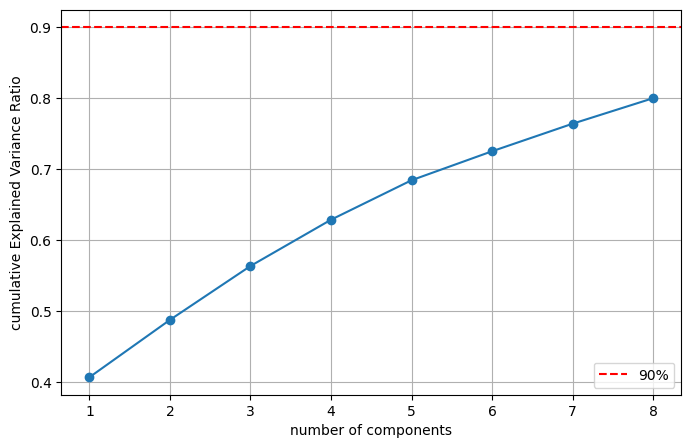

In [6]:
explained_variance_ratio = pca.explained_variance_ratio_

cumulative_variance = np.cumsum(explained_variance_ratio)

# Plot the cumulative explained variance
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
plt.xlabel('number of components')
plt.ylabel('cumulative Explained Variance Ratio')
#plt.title('Cumulative Explained Variance by PCA Components')
plt.grid(True)
plt.axhline(y=0.90, color='r', linestyle='--', label='90%')
plt.legend()
plt.show()

In [7]:
cumulative_variance

array([0.40679032, 0.48763674, 0.5635352 , 0.6287298 , 0.68436265,
       0.72520596, 0.7640338 , 0.79997724], dtype=float32)

## plot the new feature distributions

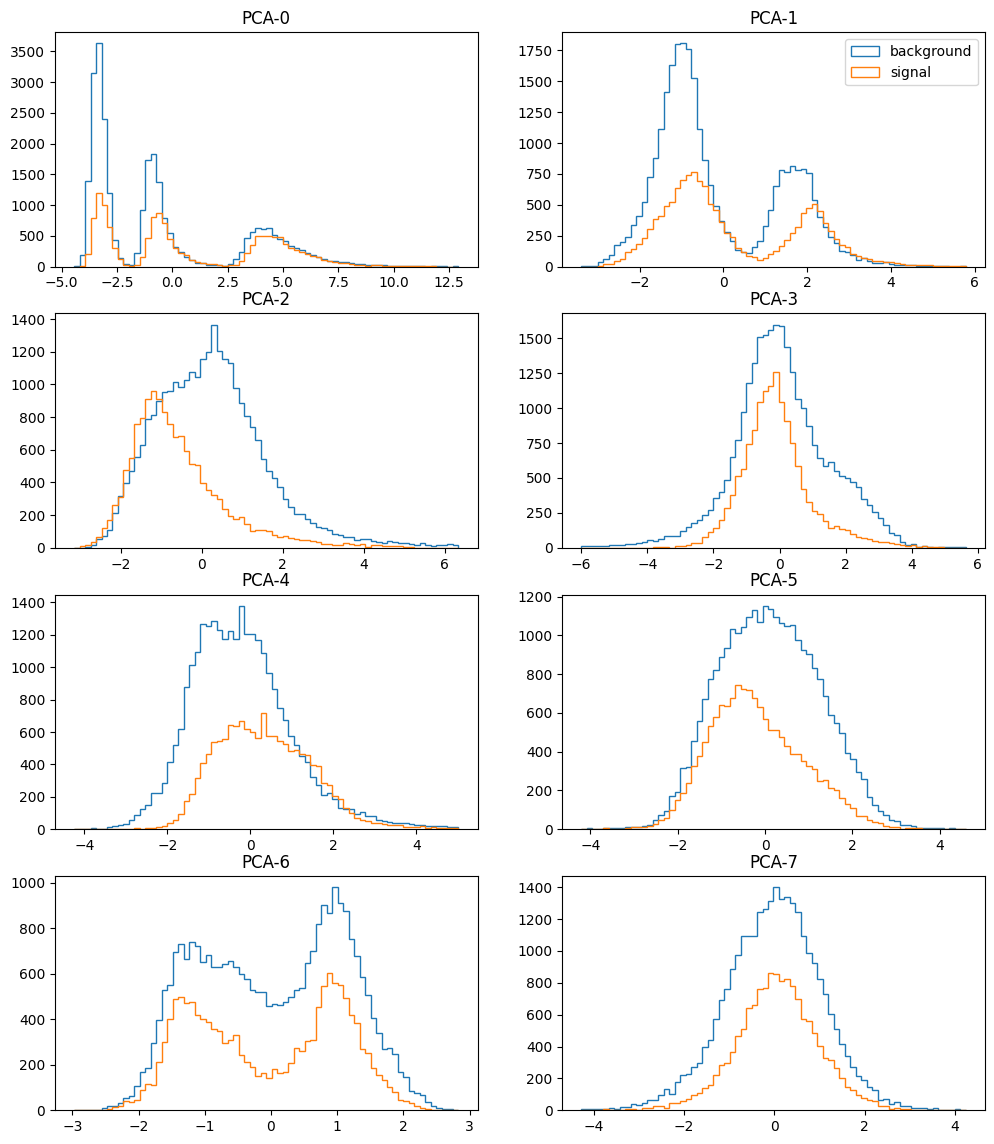

In [8]:
fig, axs = plt.subplots(4, int(n_components/4), figsize=(12,14))

for i, ax in enumerate(axs.flatten()):
    counts, bins, _ = ax.hist(x_train[~y_train.astype(bool), i], bins=70, label=f'background', histtype='step', )
    ax.hist(x_train[y_train.astype(bool), i], bins=bins, label=f'signal', histtype='step')
    ax.set_title(f'PCA-{i}')

axs[0][1].legend()

plt.show()

In [9]:
x_train.shape

(42500, 8)

In [13]:
corr = np.corrcoef(x_train[y_train.astype(bool)].T)

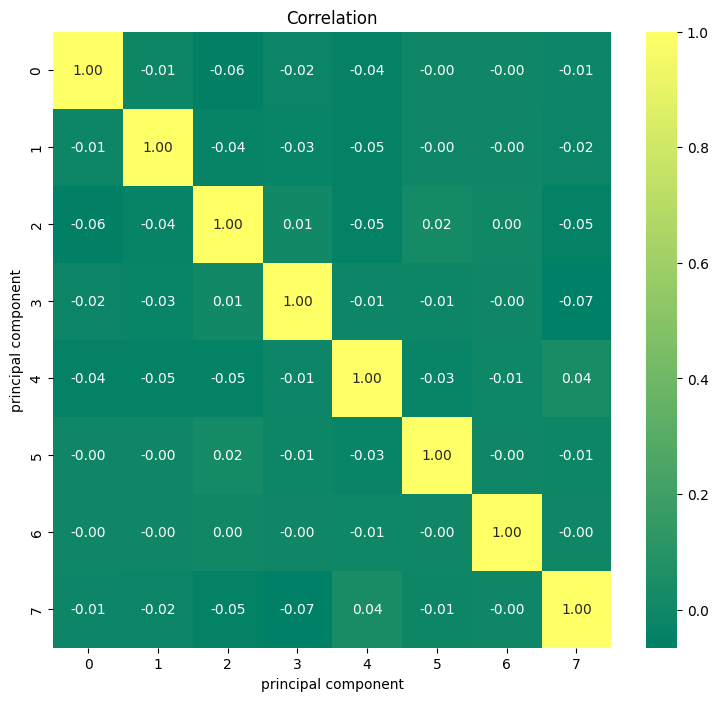

In [32]:
#x_train[y_train.astype(bool)] = remove_outliers(x_train[y_train.astype(bool)])
#x_train[~y_train.astype(bool)] = remove_outliers(x_train[~y_train.astype(bool)])

#corr = np.corrcoef(x_train[y_train.astype(bool)].T)
corr = np.corrcoef(x_train.T)
import seaborn as sns

plt.figure(figsize=(9,8))
sns.heatmap(corr, annot=True, cmap='summer', fmt='.2f')
plt.title("Correlation")
plt.xlabel('principal component')
plt.ylabel('principal component')
plt.show()

## AMS and functions

In [33]:
def ams_score(x, y, w, cut):
# Calculate Average Mean Significane as defined in ATLAS paper
#    -  approximative formula for large statistics with regularisation
# x: array of truth values (1 if signal)
# y: array of classifier result
# w: array of event weights
# cut
    t = y > cut 
    s = np.sum((x[t] == 1)*w[t])
    b = np.sum((x[t] == 0)*w[t])
    return s/np.sqrt(b+10.0)

def find_best_ams_score(x, y, w):
# find best value of AMS by scanning cut values; 
# x: array of truth values (1 if signal)
# y: array of classifier results
# w: array of event weights
#  returns 
#   ntuple of best value of AMS and the corresponding cut value
#   list with corresponding pairs (ams, cut) 
# ----------------------------------------------------------
    ymin=min(y) # classifiers may not be in range [0.,1.]
    ymax=max(y)
    nprobe=200    # number of (equally spaced) scan points to probe classifier 
    amsvec= [(ams_score(x, y, w, cut), cut) for cut in np.linspace(ymin, ymax, nprobe)] 
    maxams=sorted(amsvec, key=lambda lst: lst[0] )[-1]
    return maxams, amsvec

def ams_wrapper(prediction, true_values, weights):
    return find_best_ams_score(true_values, prediction, weights)[0][0]


def printScoreTest(model):
    try:
        pred_clf = model.predict_proba(x_test)[:, 1]
    except:
        pred_clf = model.predict(x_test)
        pred_clf = pred_clf.reshape((pred_clf.shape[0],))

    auc = roc_auc_score(y_test, pred_clf, sample_weight=weights_test)
    print('AUC:', auc)
    bs = find_best_ams_score(y_test, pred_clf, weights_test)
    print('AMS:', bs[0][0])
    print('AMS total:', bs[0][0]*np.sqrt(50))


def printScore(model):
    try:
        pred_clf = model.predict_proba(x_val)[:, 1]
    except:
        pred_clf = model.predict(x_val)
        pred_clf = pred_clf.reshape((pred_clf.shape[0],))

    auc = roc_auc_score(y_val, pred_clf, sample_weight=w_val)
    print('AUC:', auc)
    bs = find_best_ams_score(y_val, pred_clf, w_val)
    print('AMS:', bs[0][0])
    print('AMS total:', bs[0][0]*np.sqrt(50))



## Kernel Density Estimator Classifier

In [75]:
import numpy as np
from sklearn.neighbors import KernelDensity

class Classifier:
    def __init__(self):
        self.signal_kde = None
        self.background_kde = None

    def train(self, x_train, y_train, bandwidth='scott', sample_weight=None):
        """
        Trains two KDEs for signal and background data.

        Parameters:
        - x_train: numpy array of shape (n_samples, n_features)
        - y_train: numpy array of boolean values (signal=1, background=0)
        - bandwidth: bandwidth for KDE
        - sample_weightarray-like of shape (n_samples,), default=None
        """
        # Separate signal and background
        signal_data = x_train[y_train.astype(bool)]
        background_data = x_train[~y_train.astype(bool)]
        signal_weight = sample_weight[y_train.astype(bool)]
        background_weight = sample_weight[~y_train.astype(bool)]

        # Initialize and fit KDEs
        self.signal_kde = KernelDensity(bandwidth=bandwidth).fit(signal_data, sample_weight=signal_weight)
        print('Signal KDE calculated!')
        self.background_kde = KernelDensity(bandwidth=bandwidth).fit(background_data, sample_weight=background_weight)
        print('Background KDE calculated!')

    def calculateLLR(self, x):
        """
        Calculate the log-likelihood ratios for the signal and background hypotheses.

        Parameters:
        - x: numpy array of shape (n_samples, n_features)

        Returns:
        - log_likelihood_ratio: numpy array of log-likelihood ratios
        """
        # Calculate log-likelihood for signal and background
        log_likelihood_signal = self.signal_kde.score_samples(x)
        print('Signal Likelihood calculated!')
        log_likelihood_background = self.background_kde.score_samples(x)
        print('Background Likelihood calculated!')

        # Compute the log-likelihood ratio
        log_likelihood_ratio = log_likelihood_signal - log_likelihood_background

        return log_likelihood_ratio
        
    def predict(self, x):
        """
        Predict the class labels (signal or background) for the given input data.

        Parameters:
        - x: numpy array of shape (n_samples, n_features), input data

        Returns:
        - probs: numpy array of predicted labels (0 for background, 1 for signal)
        """
        llr = self.calculateLLR(x)
        print(f'calculated llr')

        probs = np.zeros_like(llr)
        probs[llr > self.critical_value] = 1

        return probs

    
    def findCriticalValue(self, x_val, y_val, w_val, scorer_function, num_points=100):
        """
        Find the best critical value for the log-likelihood ratio using validation data.

        Parameters:
        - x_val: numpy array of shape (n_samples, n_features), validation data
        - y_val: numpy array of boolean values, true labels for validation data
        - w_val: numpy array of weights of y_val
        - scorer_function: function that evaluates the performance (e.g., ams_scorer)
        - num_points: number of points to evaluate for finding the critical value

        Returns:
        - best_critical_value: the critical value that maximizes the scorer function
        """
        # Calculate log-likelihood ratios for the validation set
        llr = self.calculateLLR(x_val)

        # Determine the range for searching critical values
        min_llr, max_llr = np.min(llr), np.max(llr)
        thresholds = np.linspace(min_llr, max_llr, num_points)

        best_score = -np.inf
        best_critical_value = None

        for threshold in thresholds:
            # Predict signal or background based on the threshold
            y_pred = llr > threshold
            # Calculate the score
            score = scorer_function(y_pred, y_val, w_val)

            if score > best_score:
                best_score = score
                best_critical_value = threshold

        print(f'Best critical value {best_critical_value} for validation score: {best_score}')

        self.critical_value = best_critical_value
        return best_critical_value

In [76]:
0.5032476990283717

0.5032476990283717

## Gaussian Mixture Classifier

In [112]:
import numpy as np
from sklearn.mixture import GaussianMixture

class GMClassifier:
    def __init__(self, n_components_signal=5, n_components_background=5):
        self.n_components_signal = n_components_signal
        self.n_components_background = n_components_background
    
    def train(self, x_train, y_train, sample_weight=None):
        """
        Trains two GMMs for signal and background data.

        Parameters:
        - X: array-like of shape (n_samples, n_features)
            The input samples.
        - y: array-like of shape (n_samples,)
            The target values (binary labels: 0 for background, 1 for signal).
        """

        # Separate signal and background
        signal_data = x_train[y_train.astype(bool)]
        background_data = x_train[~y_train.astype(bool)]
        

        # Initialize and fit GMs
        self.signal_gm = GaussianMixture(n_components=self.n_components_signal, n_init=1, random_state=1) # random_state=1, max_iter=200, tol=1e-4)
        self.background_gm = GaussianMixture(n_components=self.n_components_background, n_init=1, random_state=1)# random_state=1, max_iter=200, tol=1e-4)
        self.signal_gm.fit(signal_data)
        print('Signal GM calculated!')
        self.background_gm.fit(background_data)
        print('Background GM calculated!')

    
    def calculateLLR(self, x):
        """
        Calculate the log-likelihood ratios for the signal and background hypotheses.

        Parameters:
        - x: numpy array of shape (n_samples, n_features)

        Returns:
        - log_likelihood_ratio: numpy array of log-likelihood ratios
        """
        # Calculate log-likelihood for signal and background
        log_likelihood_signal = self.signal_gm.score_samples(x)
        print('Signal Likelihood calculated!')
        log_likelihood_background = self.background_gm.score_samples(x)
        print('Background Likelihood calculated!')

        # Compute the log-likelihood ratio
        log_likelihood_ratio = log_likelihood_signal - log_likelihood_background

        return log_likelihood_ratio
        
    def predict(self, x):
        """
        Predict the class labels (signal or background) for the given input data.

        Parameters:
        - x: numpy array of shape (n_samples, n_features), input data

        Returns:
        - probs: numpy array of predicted labels (0 for background, 1 for signal)
        """
        llr = self.calculateLLR(x)
        print(f'calculated llr')

        probs = np.zeros_like(llr)
        probs[llr > self.critical_value] = 1

        return probs

    
    def findCriticalValue(self, x_val, y_val, w_val, scorer_function, num_points=100):
        """
        Find the best critical value for the log-likelihood ratio using validation data.

        Parameters:
        - x_val: numpy array of shape (n_samples, n_features), validation data
        - y_val: numpy array of boolean values, true labels for validation data
        - w_val: numpy array of weights of y_val
        - scorer_function: function that evaluates the performance (e.g., ams_scorer)
        - num_points: number of points to evaluate for finding the critical value

        Returns:
        - best_critical_value: the critical value that maximizes the scorer function
        """
        # Calculate log-likelihood ratios for the validation set
        llr = self.calculateLLR(x_val)

        # Determine the range for searching critical values
        min_llr, max_llr = np.min(llr), np.max(llr)
        thresholds = np.linspace(min_llr, max_llr, num_points)

        best_score = -np.inf
        best_critical_value = None

        for threshold in thresholds:
            # Predict signal or background based on the threshold
            y_pred = llr > threshold
            # Calculate the score
            score = scorer_function(y_pred, y_val, w_val)

            if score > best_score:
                best_score = score
                best_critical_value = threshold

        print(f'Best critical value {best_critical_value} for validation score: {best_score}')

        self.critical_value = best_critical_value
        return best_critical_value

In [113]:
gmclf = GMClassifier(n_components_signal=5, n_components_background=5)
gmclf.train(x_train=x_train, y_train=y_train, sample_weight=w_train)
print('Training done!')

Signal GM calculated!
Background GM calculated!
Training done!


In [114]:
crit_val = gmclf.findCriticalValue(x_val, y_val, w_val, scorer_function=ams_wrapper, num_points=100)

Signal Likelihood calculated!
Background Likelihood calculated!
Best critical value 0.551346122263288 for validation score: 0.20971365455604268


In [115]:
predictions = gmclf.predict(x_test)

Signal Likelihood calculated!
Background Likelihood calculated!
calculated llr


In [116]:
ams_wrapper(predictions, y_test, w_test)

0.4755970680710748

In [61]:
# test
0.4431097189820447 #n_components: 5,  #pca:12,  #no smote
0.4593890207956489  #n_components: 5,  #pca:12,  # smote
0.49246356543753705 ##n_components: 5,  #pca:8,  # smote
0.48456626551419574 # n_components: 5,  #pca: 11,  # smote, all random states: 1
0.44581050251173504 # n_components: 5,  #pca:11,  # no smote, all random states: 1
0.4755970680710748 # n_components: 5,  #pca:8,  # no smote, all random states: 1


0.48456626551419574

In [62]:
x_train.shape

(52664, 11)

## BayesianGaussianMixture

In [34]:
import numpy as np
from sklearn.mixture import BayesianGaussianMixture

class BGMClassifier:
    def __init__(self, n_components_signal=5, n_components_background=5):
        self.n_components_signal = n_components_signal
        self.n_components_background = n_components_background
    
    def train(self, x_train, y_train):
        """
        Trains two Bayesian GMMs for signal and background data.

        Parameters:
        - x_train: array-like of shape (n_samples, n_features)
            The input samples.
        - y_train: array-like of shape (n_samples,)
            The target values (binary labels: 0 for background, 1 for signal).
        - sample_weight: array-like of shape (n_samples,), optional
            The sample weights for training.
        """
        # Separate signal and background
        self.signal_data = x_train[y_train.astype(bool)]
        self.background_data = x_train[~y_train.astype(bool)]
        

        # Initialize and fit Bayesian GMs
        self.signal_bgm = BayesianGaussianMixture(n_components=self.n_components_signal, n_init=1, init_params='k-means++', random_state=1, max_iter=1000, tol=5e-4, warm_start=True)
        self.background_bgm = BayesianGaussianMixture(n_components=self.n_components_background, n_init=1, init_params='k-means++', random_state=1, max_iter=1000, tol=5e-4, warm_start=True)
        #init_params='random_from_data', 
        
        self.signal_bgm.fit(self.signal_data)
        print('Signal BGM calculated!')
        self.background_bgm.fit(self.background_data)
        print('Background BGM calculated!')

    def calculateLLR(self, x):
        """
        Calculate the log-likelihood ratios for the signal and background hypotheses.

        Parameters:
        - x: numpy array of shape (n_samples, n_features)

        Returns:
        - log_likelihood_ratio: numpy array of log-likelihood ratios
        """
        # Calculate log-likelihood for signal and background
        log_likelihood_signal = self.signal_bgm.score_samples(x)
        print('Signal Likelihood calculated!')
        log_likelihood_background = self.background_bgm.score_samples(x)
        print('Background Likelihood calculated!')

        # Compute the log-likelihood ratio
        log_likelihood_ratio = log_likelihood_signal - log_likelihood_background

        return log_likelihood_ratio
        
    def predict(self, x):
        """
        Predict the class labels (signal or background) for the given input data.

        Parameters:
        - x: numpy array of shape (n_samples, n_features), input data

        Returns:
        - probs: numpy array of predicted labels (0 for background, 1 for signal)
        """
        llr = self.calculateLLR(x)
        print(f'calculated llr')

        probs = np.zeros_like(llr)
        probs[llr > self.critical_value] = 1

        return probs

    def findCriticalValue(self, x_val, y_val, w_val, scorer_function, num_points=100):
        """
        Find the best critical value for the log-likelihood ratio using validation data.

        Parameters:
        - x_val: numpy array of shape (n_samples, n_features), validation data
        - y_val: numpy array of boolean values, true labels for validation data
        - w_val: numpy array of weights of y_val
        - scorer_function: function that evaluates the performance (e.g., ams_scorer)
        - num_points: number of points to evaluate for finding the critical value

        Returns:
        - best_critical_value: the critical value that maximizes the scorer function
        """
        # Calculate log-likelihood ratios for the validation set
        llr = self.calculateLLR(x_val)

        # Determine the range for searching critical values
        min_llr, max_llr = np.min(llr), np.max(llr)
        thresholds = np.linspace(min_llr, max_llr, num_points)

        best_score = -np.inf
        best_critical_value = None

        for threshold in thresholds:
            # Predict signal or background based on the threshold
            y_pred = llr > threshold
            # Calculate the score
            score = scorer_function(y_pred, y_val, w_val)

            if score > best_score:
                best_score = score
                best_critical_value = threshold

        print(f'Best critical value {best_critical_value} for validation score: {best_score}')

        self.critical_value = best_critical_value
        return best_critical_value, best_score

    
    def plotDistributions(self):
        """
        Plots the histograms of training signal and background data along with the fitted
        Bayesian Gaussian Mixture distributions for each feature. Signal plots
        are on the left, background plots are on the right.
        """
        def gaussian(x, mean, covariance):
            """Return the value of a Gaussian distribution with given mean and covariance."""
            return np.exp(-0.5 * ((x - mean) ** 2) / covariance) / np.sqrt(2 * np.pi * covariance)
        
        def plotHistogramAndFits(ax, label, data, color, weights, means, covs):
            """Plot histogram and Gaussian mixture components."""
            
            ax.hist(data, bins=50, density=True, alpha=0.5, color=color)
            x_range = np.linspace(data.min(), data.max(), 500)
            
            total_mixture = 0
            for weight, mean, cov in zip(weights, means, covs):
                this_gauss = weight * gaussian(x_range, mean, cov)
                total_mixture += this_gauss
                ax.plot(x_range, this_gauss, color=color, linestyle='--')
            ax.plot(x_range, total_mixture, color='k', linestyle='-')
            
            ax.set_xlim(data.min(), data.max())
            ax.set_title(label)

        signal_data = self.signal_data
        background_data = self.background_data
        n_features = signal_data.shape[1]
        n_rows = n_features // 2  # Assume an even number of features
        fig, axes = plt.subplots(n_rows * 2, 2, figsize=(12, 4 * n_rows * 2))

        for i in range(n_features):
            row = i
            col_signal = 0
            col_background = 1

            # Plot for signal
            ax_signal = axes[row, col_signal]
            plotHistogramAndFits(ax_signal, f'Feature {i + 1} - Signal', 
                                 signal_data[:, i], 'blue', 
                                 self.signal_bgm.weights_, 
                                 self.signal_bgm.means_[:, i], 
                                 self.signal_bgm.covariances_[:, i, i])

            # Plot for background
            ax_background = axes[row, col_background]
            plotHistogramAndFits(ax_background, f'Feature {i + 1} - Background', 
                                 background_data[:, i], 'red', 
                                 self.background_bgm.weights_, 
                                 self.background_bgm.means_[:, i], 
                                 self.background_bgm.covariances_[:, i, i])

        plt.tight_layout()
        plt.show()

In [35]:
bgmclf = BGMClassifier(n_components_signal=8, n_components_background=8)
bgmclf.train(x_train=x_train, y_train=y_train)

Signal BGM calculated!
Background BGM calculated!


In [36]:
crit_val = bgmclf.findCriticalValue(x_val, y_val, w_val, scorer_function=ams_wrapper, num_points=100)
predictions = bgmclf.predict(x_test)
print()
print(ams_wrapper(predictions, y_test, w_test))

Signal Likelihood calculated!
Background Likelihood calculated!
Best critical value 1.4219307362484592 for validation score: 0.2130474514002171
Signal Likelihood calculated!
Background Likelihood calculated!
calculated llr

0.5076262657187113


In [37]:
0.4654259164461205 #8
0.45910733291607686# 6
0.4945670154657519 #n_components_signal:7 # random state:1 #pca:8 #kmeansg
0.49823209329938867 #n_components_signal:7 # random state:1 #pca:8 #kmeans++
 

0.49823209329938867

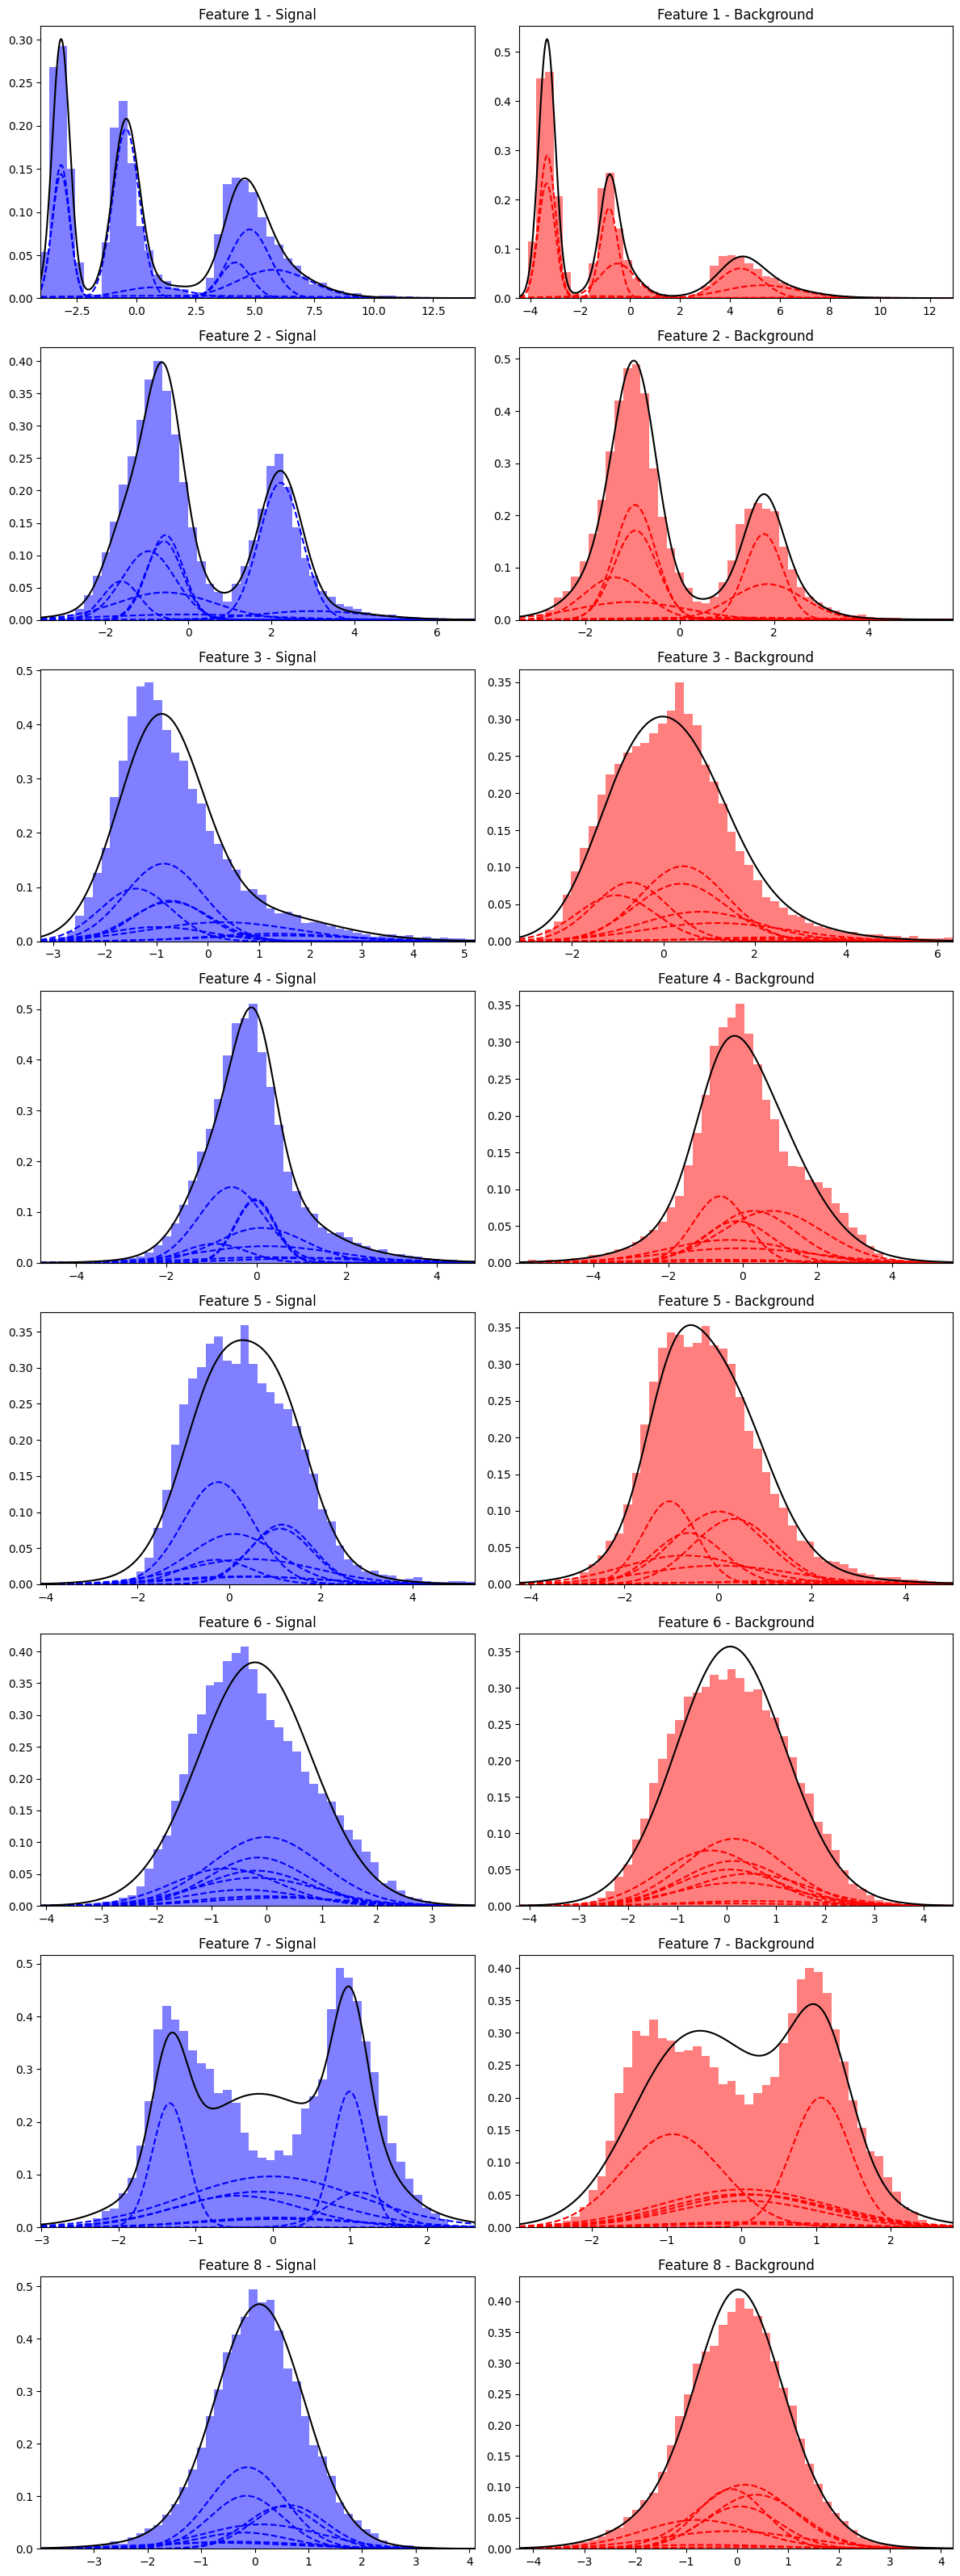

In [38]:
bgmclf.plotDistributions()

### test to optimize hyperparameter

In [416]:
n_components_range = range(3, 11)  
best_scores = []

for i, n_components_signal in enumerate(n_components_range):
    n_components_background = n_components_signal
    print(f"Testing with n_components_signal={n_components_signal}, n_components_background={n_components_background}")
    
    # Initialize and train the classifier
    bgmclf = BGMClassifier(n_components_signal=n_components_signal, n_components_background=n_components_background)
    bgmclf.train(x_train=x_train, y_train=y_train)
    
    # Find the critical value and get the best score
    crit_val, best_score = bgmclf.findCriticalValue(x_val, y_val, w_val, scorer_function=ams_wrapper, num_points=100)
    
    # Store the best score in the 2D array
    best_scores.append(best_score)

# Print the results
print("\nBest scores for different combinations of n_components:")
print(best_scores)

# Find the best overall configuration
best_i, best_j = np.unravel_index(np.argmax(best_scores), best_scores.shape)
best_n_components_signal = n_components_range[best_i]
best_n_components_background = n_components_range[best_j]
best_overall_score = best_scores[best_i, best_j]

print(f"\nBest overall configuration:")
print(f"n_components_signal: {best_n_components_signal}")
print(f"n_components_background: {best_n_components_background}")
print(f"Best score: {best_overall_score}")

Testing with n_components_signal=3, n_components_background=3
Signal BGM calculated!
Background BGM calculated!
Signal Likelihood calculated!
Background Likelihood calculated!
Best critical value -0.037728512363912614 for validation score: 0.19644255883199768
Testing with n_components_signal=4, n_components_background=4
Signal BGM calculated!
Background BGM calculated!
Signal Likelihood calculated!
Background Likelihood calculated!
Best critical value 1.11268864018259 for validation score: 0.2134676778858641
Testing with n_components_signal=5, n_components_background=5
Signal BGM calculated!
Background BGM calculated!
Signal Likelihood calculated!
Background Likelihood calculated!
Best critical value 1.3346319625511 for validation score: 0.21364572387356592
Testing with n_components_signal=6, n_components_background=6
Signal BGM calculated!
Background BGM calculated!
Signal Likelihood calculated!
Background Likelihood calculated!
Best critical value 0.5438962216969472 for validation sc

AttributeError: 'list' object has no attribute 'shape'

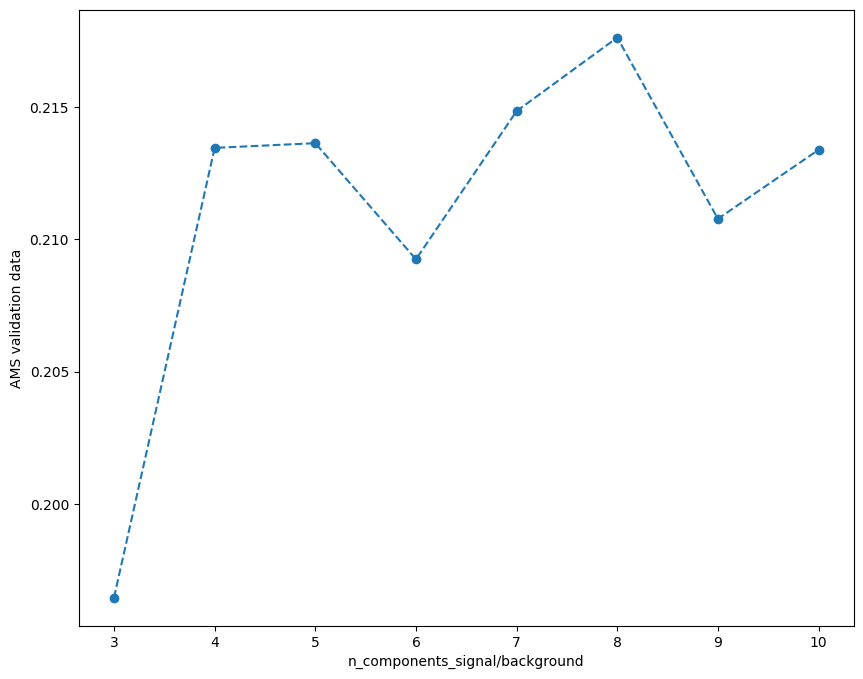

In [417]:
import seaborn as sns

plt.figure(figsize=(10, 8))
plt.plot(n_components_range, best_scores, 'o--')
plt.xlabel('n_components_signal/background')
plt.ylabel('AMS validation data')
plt.show()

## GMC 2

In [374]:
tt = gmclf.signal_gm.precisions_


In [375]:
class GMClassifier2:
    def __init__(self, n_components_signal=5, n_components_background=5):
        self.n_components_signal = n_components_signal
        self.n_components_background = n_components_background
    
    def train(self, x_train, y_train):
        """
        Trains two Gaussian Mixture Models for signal and background data.

        Parameters:
        - x_train: array-like of shape (n_samples, n_features)
            The input samples.
        - y_train: array-like of shape (n_samples,)
            The target values (binary labels: 0 for background, 1 for signal).
        """
        # Separate signal and background
        self.signal_data = x_train[y_train.astype(bool)]
        self.background_data = x_train[~y_train.astype(bool)]

        means_init = np.array([[ 4.607344  , -0.32288648,  1.46562274,  5.47900274, -3.17695733],
       [-1.07959155,  2.30571351,  0.79556143, -0.77436353, -0.56705308],
       [-1.41721702, -0.67815162,  1.55701853,  0.07593935, -0.716989  ],
       [-0.09854451, -0.49258639,  1.26281077,  0.02722837, -0.02237134],
       [-0.01133591, -0.19941157,  0.55975472,  0.36075942,  1.12627671],
       [-0.18024512, -0.03957748,  0.32804488, -0.26306095, -0.47290878],
       [-1, -0.0149694 ,  1, -0.06309298, -0.14140413],
       [-0.14612338, -0.12250041, -0.76579852,  0.01468752,  0.57352756]]).T

        prec_init = tt

        # Initialize and fit Gaussian Mixture Models
        self.signal_gm = GaussianMixture(n_components=self.n_components_signal, n_init=1, random_state=1, means_init=means_init, precisions_init=prec_init)
        self.background_gm = GaussianMixture(n_components=self.n_components_background, n_init=1, means_init=means_init, precisions_init=prec_init)
        
        self.signal_gm.fit(self.signal_data)
        print('Signal GM calculated!')
        self.background_gm.fit(self.background_data)
        print('Background GM calculated!')

    def calculateLLR(self, x):
        """
        Calculate the log-likelihood ratios for the signal and background hypotheses.

        Parameters:
        - x: numpy array of shape (n_samples, n_features)

        Returns:
        - log_likelihood_ratio: numpy array of log-likelihood ratios
        """
        # Calculate log-likelihood for signal and background
        log_likelihood_signal = self.signal_gm.score_samples(x)
        print('Signal Likelihood calculated!')
        log_likelihood_background = self.background_gm.score_samples(x)
        print('Background Likelihood calculated!')

        # Compute the log-likelihood ratio
        log_likelihood_ratio = log_likelihood_signal - log_likelihood_background

        return log_likelihood_ratio
        
      
    def predict(self, x):
        """
        Predict the class labels (signal or background) for the given input data.

        Parameters:
        - x: numpy array of shape (n_samples, n_features), input data

        Returns:
        - probs: numpy array of predicted labels (0 for background, 1 for signal)
        """
        llr = self.calculateLLR(x)
        print(f'calculated llr')

        probs = np.zeros_like(llr)
        probs[llr > self.critical_value] = 1

        return probs

    def findCriticalValue(self, x_val, y_val, w_val, scorer_function, num_points=100):
        """
        Find the best critical value for the log-likelihood ratio using validation data.

        Parameters:
        - x_val: numpy array of shape (n_samples, n_features), validation data
        - y_val: numpy array of boolean values, true labels for validation data
        - w_val: numpy array of weights of y_val
        - scorer_function: function that evaluates the performance (e.g., ams_scorer)
        - num_points: number of points to evaluate for finding the critical value

        Returns:
        - best_critical_value: the critical value that maximizes the scorer function
        """
        # Calculate log-likelihood ratios for the validation set
        llr = self.calculateLLR(x_val)

        # Determine the range for searching critical values
        min_llr, max_llr = np.min(llr), np.max(llr)
        thresholds = np.linspace(min_llr, max_llr, num_points)

        best_score = -np.inf
        best_critical_value = None

        for threshold in thresholds:
            # Predict signal or background based on the threshold
            y_pred = llr > threshold
            # Calculate the score
            score = scorer_function(y_pred, y_val, w_val)

            if score > best_score:
                best_score = score
                best_critical_value = threshold

        print(f'Best critical value {best_critical_value} for validation score: {best_score}')

        self.critical_value = best_critical_value
        return best_critical_value

    
    def plotDistributions(self):
        """
        Plots the histograms of training signal and background data along with the fitted
        Bayesian Gaussian Mixture distributions for each feature. Signal plots
        are on the left, background plots are on the right.
        """
        def gaussian(x, mean, covariance):
            """Return the value of a Gaussian distribution with given mean and covariance."""
            return np.exp(-0.5 * ((x - mean) ** 2) / covariance) / np.sqrt(2 * np.pi * covariance)
        
        def plotHistogramAndFits(ax, label, data, color, weights, means, covs):
            """Plot histogram and Gaussian mixture components."""
            
            ax.hist(data, bins=50, density=True, alpha=0.5, color=color)
            x_range = np.linspace(data.min(), data.max(), 500)
            
            total_mixture = 0
            for weight, mean, cov in zip(weights, means, covs):
                this_gauss = weight * gaussian(x_range, mean, cov)
                total_mixture += this_gauss
                ax.plot(x_range, this_gauss, color=color, linestyle='--')
            ax.plot(x_range, total_mixture, color='k', linestyle='-')
            
            ax.set_xlim(data.min(), data.max())
            ax.set_title(label)

        signal_data = self.signal_data
        background_data = self.background_data
        n_features = signal_data.shape[1]
        n_rows = n_features // 2  # Assume an even number of features
        fig, axes = plt.subplots(n_rows * 2, 2, figsize=(12, 4 * n_rows * 2))

        for i in range(n_features):
            row = i
            col_signal = 0
            col_background = 1

            # Plot for signal
            ax_signal = axes[row, col_signal]
            plotHistogramAndFits(ax_signal, f'Feature {i + 1} - Signal', 
                                 signal_data[:, i], 'blue', 
                                 self.signal_gm.weights_, 
                                 self.signal_gm.means_[:, i], 
                                 self.signal_gm.covariances_[:, i, i])

            # Plot for background
            ax_background = axes[row, col_background]
            plotHistogramAndFits(ax_background, f'Feature {i + 1} - Background', 
                                 background_data[:, i], 'red', 
                                 self.background_gm.weights_, 
                                 self.background_gm.means_[:, i], 
                                 self.background_gm.covariances_[:, i, i])

        plt.tight_layout()
        plt.show()


In [376]:
gmclf = GMClassifier2(n_components_signal=5, n_components_background=5)
gmclf.train(x_train=x_train, y_train=y_train)

Signal GM calculated!
Background GM calculated!


In [377]:
crit_val = gmclf.findCriticalValue(x_val, y_val, w_val, scorer_function=ams_wrapper, num_points=100)
predictions = gmclf.predict(x_test)
print()
print(ams_wrapper(predictions, y_test, w_test))

Signal Likelihood calculated!
Background Likelihood calculated!
Best critical value 1.158943541921115 for validation score: 0.21239836045203744
Signal Likelihood calculated!
Background Likelihood calculated!
calculated llr

0.4848291799067173


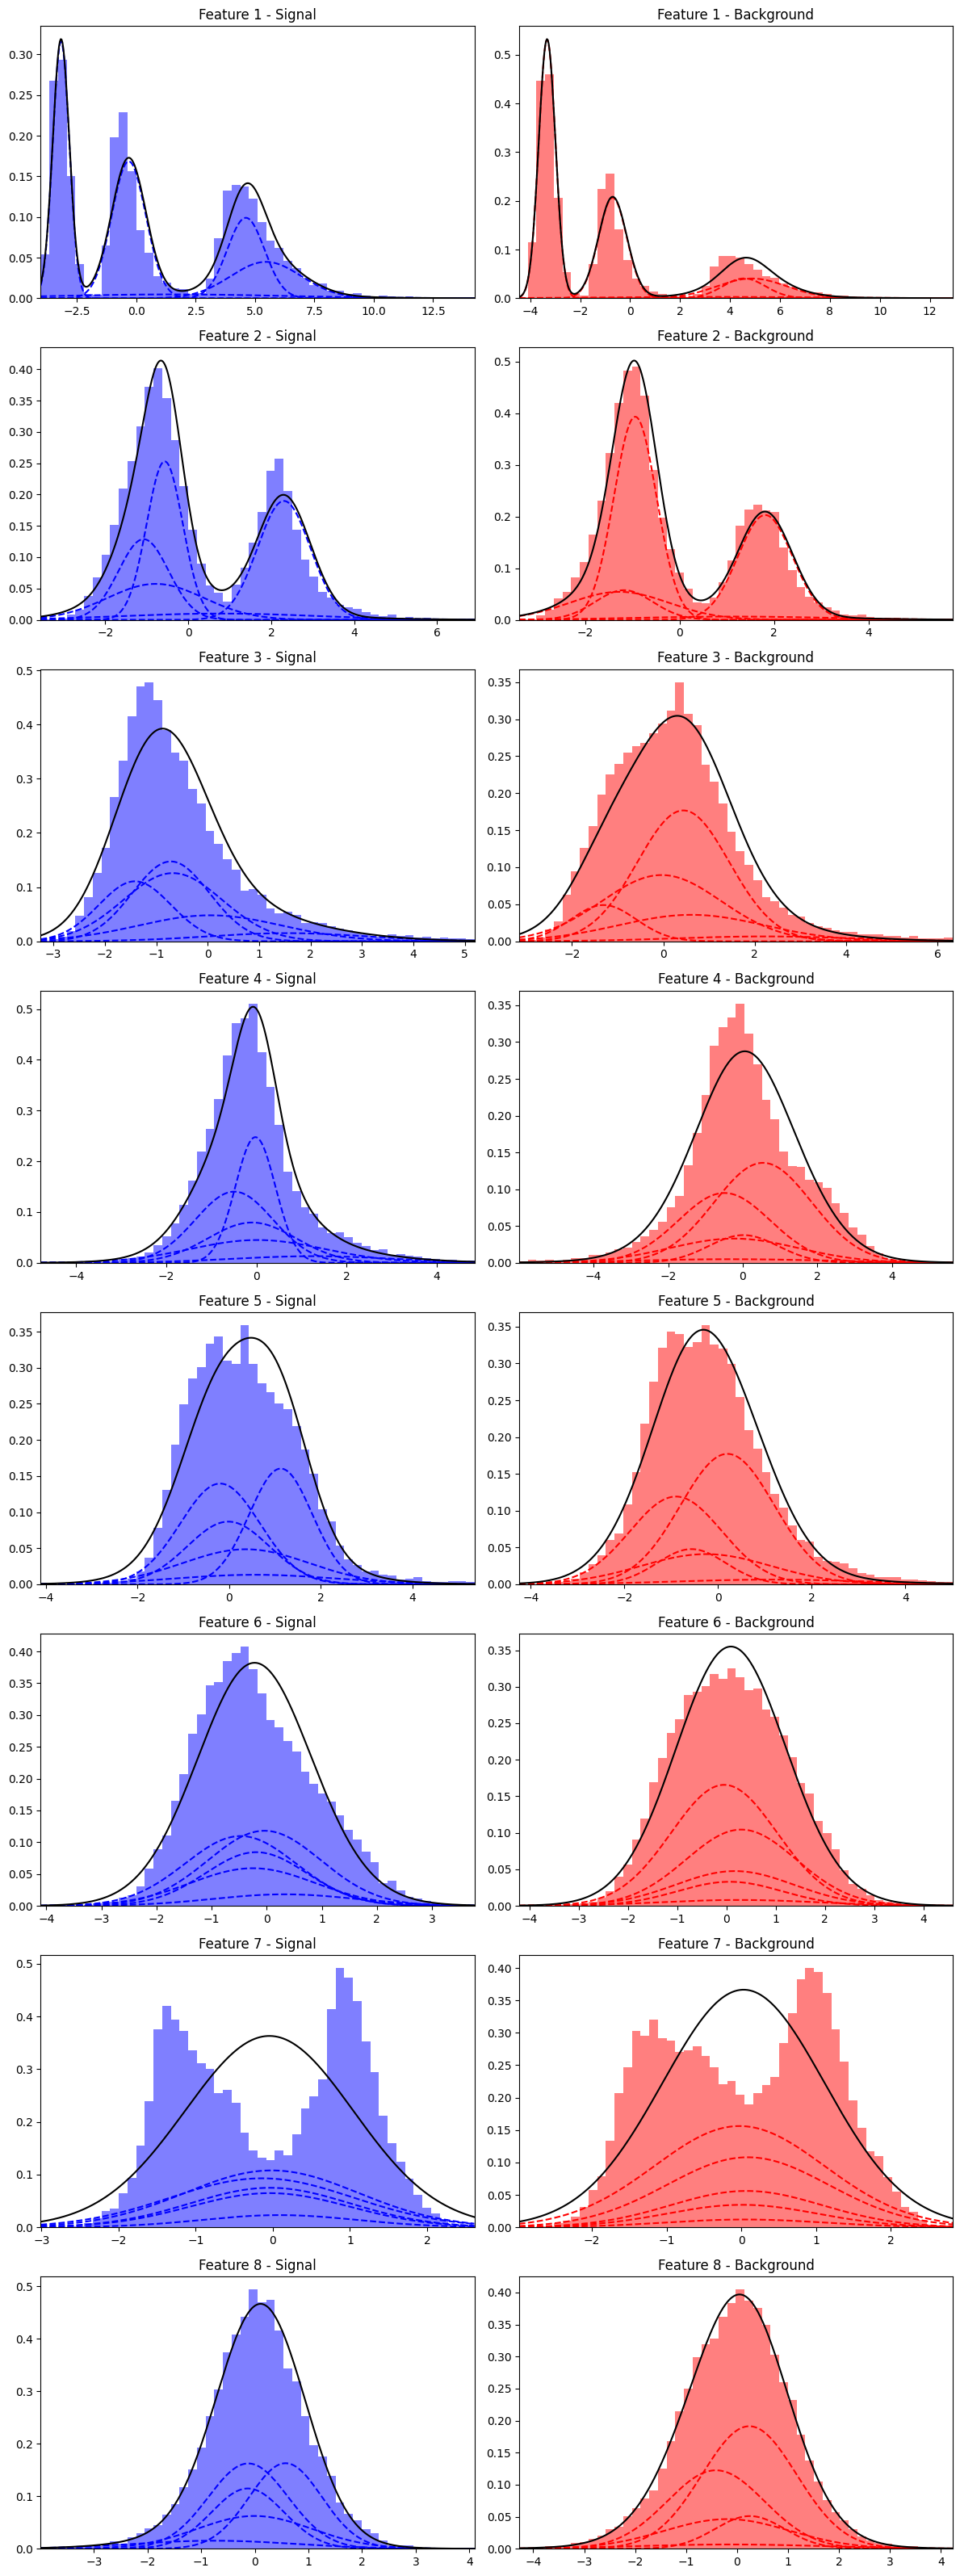

In [378]:
gmclf.plotDistributions()

In [371]:
tt2 = np.array([[ 4.607344  , -0.32288648,  1.46562274,  5.47900274, -3.17695733],
       [-1.07959155,  2.30571351,  0.79556143, -0.77436353, -0.56705308],
       [-1.41721702, -0.67815162,  1.55701853,  0.07593935, -0.716989  ],
       [-0.09854451, -0.49258639,  1.26281077,  0.02722837, -0.02237134],
       [-0.01133591, -0.19941157,  0.55975472,  0.36075942,  1.12627671],
       [-0.18024512, -0.03957748,  0.32804488, -0.26306095, -0.47290878],
       [-1, -0.0149694 ,  1, -0.06309298, -0.14140413],
       [-0.14612338, -0.12250041, -0.76579852,  0.01468752,  0.57352756]]).T

array([[ 4.607344  , -0.32288648,  1.46562274,  5.47900274, -3.17695733],
       [-1.07959155,  2.30571351,  0.79556143, -0.77436353, -0.56705308],
       [-1.41721702, -0.67815162,  1.55701853,  0.07593935, -0.716989  ],
       [-0.09854451, -0.49258639,  1.26281077,  0.02722837, -0.02237134],
       [-0.01133591, -0.19941157,  0.55975472,  0.36075942,  1.12627671],
       [-0.18024512, -0.03957748,  0.32804488, -0.26306095, -0.47290878],
       [-0.01577051, -0.0149694 ,  0.08554546, -0.06309298, -0.14140413],
       [-0.14612338, -0.12250041, -0.76579852,  0.01468752,  0.57352756]])

## GMC 3

In [51]:
from sklearn.mixture import GaussianMixture

class GMClassifier3:
    def __init__(self, n_components_signal, n_components_background):
        self.n_components_signal = n_components_signal
        self.n_components_background = n_components_background
    
    def train(self, x_train, y_train):
        """
        Trains separate Gaussian Mixture Models for each feature for signal and background data.

        Parameters:
        - x_train: array-like of shape (n_samples, n_features)
            The input samples.
        - y_train: array-like of shape (n_samples,)
            The target values (binary labels: 0 for background, 1 for signal).
        """
        # Separate signal and background
        self.signal_data = x_train[y_train.astype(bool)]
        self.background_data = x_train[~y_train.astype(bool)]

        n_features = x_train.shape[1]

        # Initialize and fit Gaussian Mixture Models for each feature
        self.signal_gms = []
        self.background_gms = []

        for i in range(n_features):
            signal_gm = GaussianMixture(n_components=self.n_components_signal[i], n_init=1, 
                                         random_state=1)
            background_gm = GaussianMixture(n_components=self.n_components_background[i], n_init=1, 
                                             random_state=1)
            
            signal_gm.fit(self.signal_data[:, i].reshape(-1, 1))
            background_gm.fit(self.background_data[:, i].reshape(-1, 1))
            
            self.signal_gms.append(signal_gm)
            self.background_gms.append(background_gm)
            print(f'Feature {i} done!')
        
        print('Signal and Background GMs calculated for all features!')

    def calculateLLR(self, x):
        """
        Calculate the log-likelihood ratios for the signal and background hypotheses.

        Parameters:
        - x: numpy array of shape (n_samples, n_features)

        Returns:
        - log_likelihood_ratio: numpy array of log-likelihood ratios
        """
        n_samples, n_features = x.shape
        log_likelihood_signal = np.zeros(n_samples)
        log_likelihood_background = np.zeros(n_samples)

        for i in range(n_features):
            signal_probs = self.signal_gms[i].predict_proba(x[:, i].reshape(-1, 1))
            background_probs = self.background_gms[i].predict_proba(x[:, i].reshape(-1, 1))
            
            log_likelihood_signal += np.log(np.sum(signal_probs, axis=1))
            log_likelihood_background += np.log(np.sum(background_probs, axis=1))

        log_likelihood_ratio = log_likelihood_signal - log_likelihood_background

        return log_likelihood_ratio
    
    def predict(self, x):
        """
        Predict the class labels (signal or background) for the given input data.

        Parameters:
        - x: numpy array of shape (n_samples, n_features), input data

        Returns:
        - probs: numpy array of predicted labels (0 for background, 1 for signal)
        """
        llr = self.calculateLLR(x)
        print(f'calculated llr')

        probs = np.zeros_like(llr)
        probs[llr > self.critical_value] = 1

        return probs

    def findCriticalValue(self, x_val, y_val, w_val, scorer_function, num_points=100):
        """
        Find the best critical value for the log-likelihood ratio using validation data.

        Parameters:
        - x_val: numpy array of shape (n_samples, n_features), validation data
        - y_val: numpy array of boolean values, true labels for validation data
        - w_val: numpy array of weights of y_val
        - scorer_function: function that evaluates the performance (e.g., ams_scorer)
        - num_points: number of points to evaluate for finding the critical value

        Returns:
        - best_critical_value: the critical value that maximizes the scorer function
        """
        # Calculate log-likelihood ratios for the validation set
        llr = self.calculateLLR(x_val)

        # Determine the range for searching critical values
        min_llr, max_llr = np.min(llr), np.max(llr)
        thresholds = np.linspace(min_llr, max_llr, num_points)

        best_score = -np.inf
        best_critical_value = None

        for threshold in thresholds:
            # Predict signal or background based on the threshold
            y_pred = llr > threshold
            # Calculate the score
            score = scorer_function(y_pred, y_val, w_val)

            if score > best_score:
                best_score = score
                best_critical_value = threshold

        print(f'Best critical value {best_critical_value} for validation score: {best_score}')

        self.critical_value = best_critical_value
        return best_critical_value
    
    def plotDistributions(self):
        """
        Plots the histograms of training signal and background data along with the fitted
        Gaussian Mixture distributions for each feature. Signal plots are on the left,
        background plots are on the right.
        """
        import matplotlib.pyplot as plt
    
        def gaussian(x, mean, covariance):
            """Return the value of a Gaussian distribution with given mean and covariance."""
            return np.exp(-0.5 * ((x - mean) ** 2) / covariance) / np.sqrt(2 * np.pi * covariance)
        
        def plotHistogramAndFits(ax, label, data, color, gm):
            """Plot histogram and Gaussian mixture components."""
            ax.hist(data, bins=100, density=True, alpha=0.5, color=color)
            x_range = np.linspace(data.min(), data.max(), 500).reshape(-1, 1)
            
            total_mixture = 0
            for i, (weight, mean, cov) in enumerate(zip(gm.weights_, gm.means_, gm.covariances_)):
                this_gauss = weight * gaussian(x_range, mean, cov)
                total_mixture += this_gauss
                ax.plot(x_range, this_gauss, color=color, linestyle='--')
            ax.plot(x_range, np.sum(total_mixture, axis=1), color='k', linestyle='-')
            
            ax.set_xlim(data.min(), data.max())
            ax.set_title(label)
    
        n_features = self.signal_data.shape[1]
        n_rows = (n_features + 1) // 2
        fig, axes = plt.subplots(n_rows, 4, figsize=(16, 4 * n_rows))
    
        for i in range(n_features):
            row, col = divmod(i, 2)
            # Plot for signal
            ax_signal = axes[row, col * 2]
            plotHistogramAndFits(ax_signal, f'Feature {i + 1} - Signal', 
                                 self.signal_data[:, i], 'blue', 
                                 self.signal_gms[i])
    
            # Plot for background
            ax_background = axes[row, col * 2 + 1]
            plotHistogramAndFits(ax_background, f'Feature {i + 1} - Background', 
                                 self.background_data[:, i], 'red', 
                                 self.background_gms[i])
    
        plt.tight_layout()
        plt.show()

In [52]:
gmclf = GMClassifier3(n_components_signal=[5]*8, n_components_background=[5]*8)
gmclf.train(x_train=x_train, y_train=y_train)

Feature 0 done!
Feature 1 done!
Feature 2 done!
Feature 3 done!
Feature 4 done!
Feature 5 done!
Feature 6 done!
Feature 7 done!
Signal and Background GMs calculated for all features!


In [53]:
crit_val = gmclf.findCriticalValue(x_val, y_val, w_val, scorer_function=ams_wrapper, num_points=100)
predictions = gmclf.predict(x_test)
print()
print(ams_wrapper(predictions, y_test, w_test))

Best critical value -2.40211890782534e-15 for validation score: 0.1088686242041224
calculated llr

0.24015157391258105


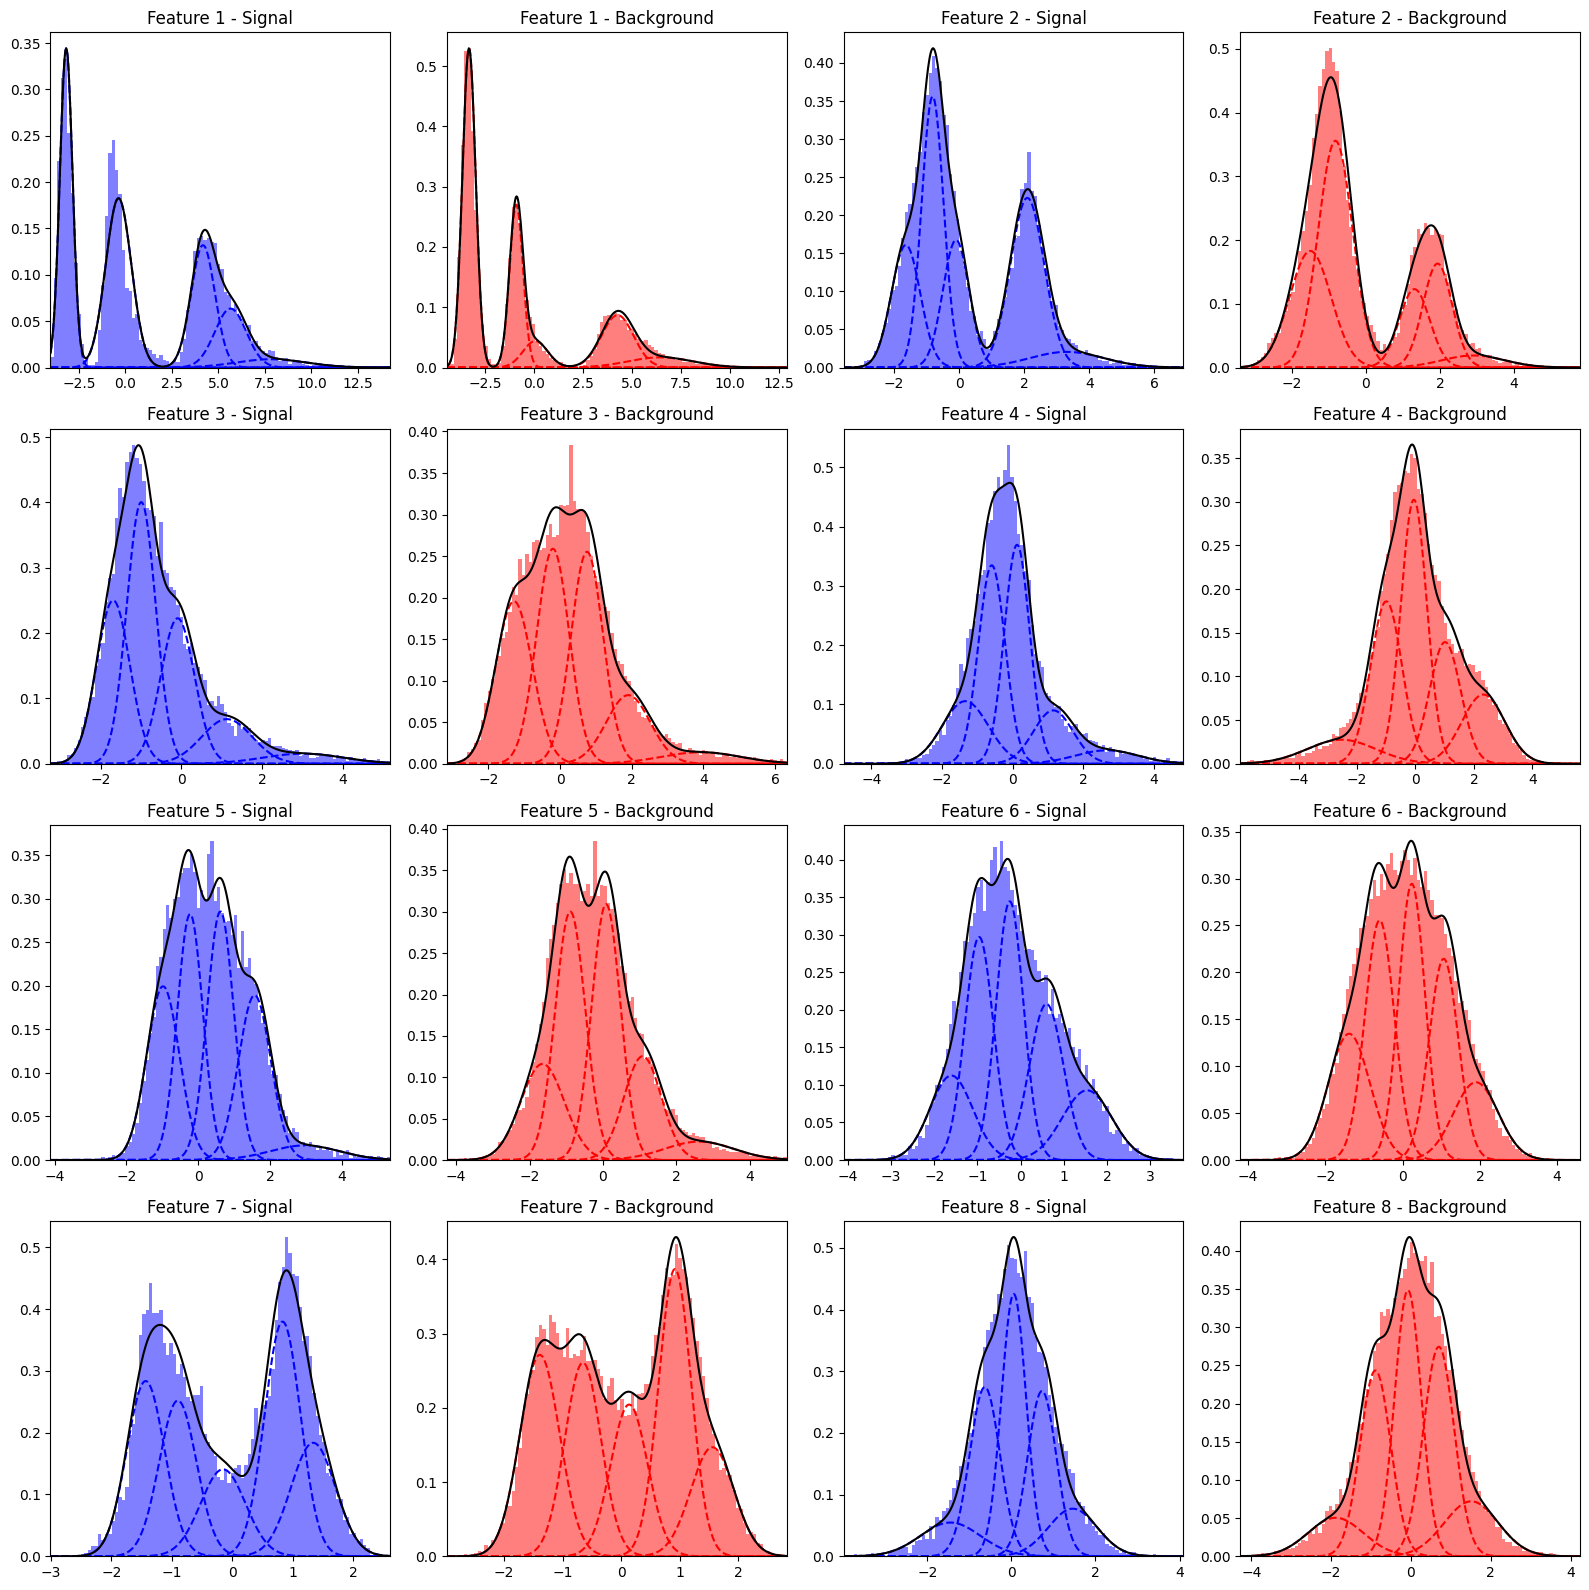

In [54]:
gmclf.plotDistributions()

In [ ]:
from sklearn.mixture import BayesianGaussianMixture

class BGMClassifier:
    def __init__(self, n_components_signal=5, n_components_background=5):
        self.n_components_signal = n_components_signal
        self.n_components_background = n_components_background
    
    def train(self, x_train, y_train):
        """
        Trains two Bayesian GMMs for signal and background data.

        Parameters:
        - x_train: array-like of shape (n_samples, n_features)
            The input samples.
        - y_train: array-like of shape (n_samples,)
            The target values (binary labels: 0 for background, 1 for signal).
        - sample_weight: array-like of shape (n_samples,), optional
            The sample weights for training.
        """
        
        # separate signal and background
        self.signal_data = x_train[y_train.astype(bool)]
        self.background_data = x_train[~y_train.astype(bool)]
        

        # initialize and fit
        self.signal_bgm = BayesianGaussianMixture(n_components=self.n_components_signal, n_init=5, init_params='k-means++', random_state=None, max_iter=1000, tol=5e-4, warm_start=True)
        self.background_bgm = BayesianGaussianMixture(n_components=self.n_components_background, n_init=5, init_params='k-means++', random_state=None, max_iter=1000, tol=5e-4, warm_start=True)
        #init_params='random_from_data', 
        
        self.signal_bgm.fit(self.signal_data)
        print('Signal BGM calculated!')
        self.background_bgm.fit(self.background_data)
        print('Background BGM calculated!')

    
    def calculateLLR(self, x):
        """
        Calculate the log-likelihood ratios for the signal and background hypotheses.

        Parameters:
        - x: numpy array of shape (n_samples, n_features)

        Returns:
        - log_likelihood_ratio: numpy array of log-likelihood ratios
        """
        
        log_likelihood_signal = self.signal_bgm.score_samples(x)
        print('Signal Likelihood calculated!')
        log_likelihood_background = self.background_bgm.score_samples(x)
        print('Background Likelihood calculated!')

        log_likelihood_ratio = log_likelihood_signal - log_likelihood_background
        return log_likelihood_ratio

    
    def predict(self, x):
        """
        Predict the class labels (signal or background) for the given input data.

        Parameters:
        - x: numpy array of shape (n_samples, n_features), input data

        Returns:
        - probs: numpy array of predicted labels (0 for background, 1 for signal)
        """
        
        llr = self.calculateLLR(x)
        probs = np.zeros_like(llr)
        probs[llr > self.critical_value] = 1
        return probs
        

    def findCriticalValue(self, x_val, y_val, w_val, scorer_function, num_points=100):
        """
        Find the best critical value for the log-likelihood ratio using validation data.

        Parameters:
        - x_val: numpy array of shape (n_samples, n_features), validation data
        - y_val: numpy array of boolean values, true labels for validation data
        - w_val: numpy array of weights of y_val
        - scorer_function: function that evaluates the performance (ams_scorer)
        - num_points: number of points to evaluate for finding the critical value

        Returns:
        - best_critical_value: the critical value that maximizes the scorer function
        """
        
        llr = self.calculateLLR(x_val)

        min_llr, max_llr = np.min(llr), np.max(llr)
        thresholds = np.linspace(min_llr, max_llr, num_points)

        best_score = -np.inf
        best_critical_value = None
        for threshold in thresholds:
            y_pred = llr > threshold
            score = scorer_function(y_pred, y_val, w_val)

            if score > best_score:
                best_score = score
                best_critical_value = threshold

        print(f'Best critical value {best_critical_value} for validation score: {best_score}')

        # store the criticial value for later classifcation use
        self.critical_value = best_critical_value
        return best_critical_value, best_score

    def plotDistributions(self):
        """
        Plots the histograms of training signal and background data along with the fitted
        Bayesian Gaussian Mixture distributions for each feature. Signal plots
        are on the left, background plots are on the right.
        """
        def gaussian(x, mean, covariance):
            """Return the value of a Gaussian distribution with given mean and covariance."""
            return np.exp(-0.5 * ((x - mean) ** 2) / covariance) / np.sqrt(2 * np.pi * covariance)
        
        def plotHistogramAndFits(ax, label, data, color, weights, means, covs):
            """Plot histogram and Gaussian mixture components."""
            
            ax.hist(data, bins=50, density=True, alpha=0.5, color=color)
            x_range = np.linspace(data.min(), data.max(), 500)
            
            total_mixture = 0
            for weight, mean, cov in zip(weights, means, covs):
                this_gauss = weight * gaussian(x_range, mean, cov)
                total_mixture += this_gauss
                ax.plot(x_range, this_gauss, color=color, linestyle='--')
            ax.plot(x_range, total_mixture, color='k', linestyle='-')
            
            ax.set_xlim(data.min(), data.max())
            ax.set_title(label)

        signal_data = self.signal_data
        background_data = self.background_data
        n_features = signal_data.shape[1]
        n_rows = (n_features + 1) // 2 

        fig, axes = plt.subplots(n_rows, 4, figsize=(16, 4 * n_rows))

        for i in range(n_features):
            row = i // 2  # 2 features on one row
            col_signal = 2 * (i % 2) # signal: even cols
            col_background = col_signal + 1 # bg: odd cols

            #signal
            ax_signal = axes[row, col_signal]
            plotHistogramAndFits(ax_signal, f'Feature {i + 1} - Signal', 
                                 signal_data[:, i], 'blue', 
                                 self.signal_bgm.weights_, 
                                 self.signal_bgm.means_[:, i], 
                                 self.signal_bgm.covariances_[:, i, i])

            #background 
            ax_background = axes[row, col_background]
            plotHistogramAndFits(ax_background, f'Feature {i + 1} - Background', 
                                 background_data[:, i], 'red', 
                                 self.background_bgm.weights_, 
                                 self.background_bgm.means_[:, i], 
                                 self.background_bgm.covariances_[:, i, i])

        plt.tight_layout()
        plt.show()
